In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import shutil, os

In [67]:
h_pixels = np.load('h_pixels_screen.npy')
v_pixels = np.load('v_pixels_screen.npy')

In [2]:
def arr_creat(upperleft, upperright, lowerleft, lowerright):
    arr = np.linspace(np.linspace(lowerleft, lowerright, arrwidth), 
                      np.linspace(upperleft, upperright, arrwidth), arrheight, dtype=int)
    return arr[:, :, None]

arrwidth = 1920
arrheight = 1080

r = arr_creat(0,   255, 0,   255)
g = arr_creat(0,   0,   255, 0)
b = arr_creat(255, 255, 0,   0)

img = np.concatenate([r, g, b], axis=2)

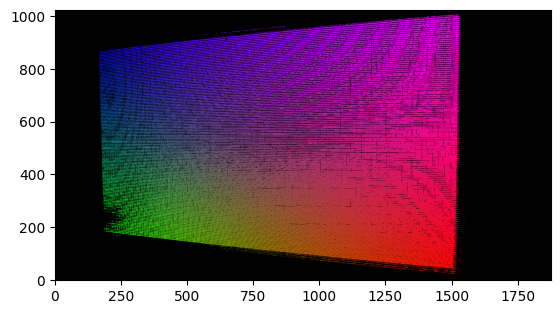

In [69]:
result_img = np.zeros((h_pixels.shape[0], h_pixels.shape[1], 3), dtype=int)

for i in range(h_pixels.shape[1]):
    for j in range(h_pixels.shape[0]):
        h_value = h_pixels[j, i]
        v_value = v_pixels[j, i]
        if h_value == -1 or v_value == -1:
            result_img[j, i] = [0, 0, 0]
        else:
            h_value = min(1919, h_value)
            v_value = min(1079, v_value)
            #print(h_value, v_value)
            result_img[j, i] = img[v_value, h_value]

plt.imshow(result_img, origin="lower")

# Show the plot
plt.show()


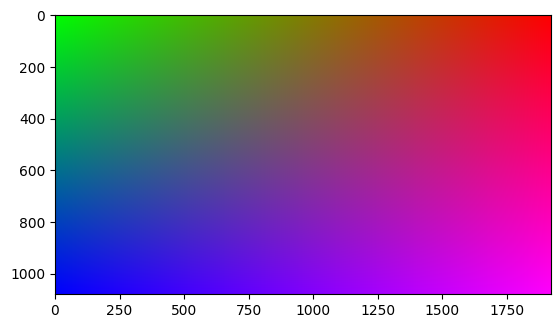

In [9]:
plt.imshow(img)

In [3]:
h_codes = np.load('../data/h_codes.npy')
v_codes = np.load('../data/v_codes.npy')

In [29]:
test_reshape = np.reshape(h_codes, (h_codes.shape[1]* h_codes.shape[2], -1))
modified = test_reshape.copy()
modified2 = test_reshape.copy()
test_reshape[0][3] = 1
modified2[0][3] = -1

print(test_reshape[0])
modified[0][3] = 0
modified[0][4] = 1
print(modified[0])
print(modified2[0])

result = np.max([test_reshape, modified, modified2], axis=0)
print(result[0])

[-1 -1 -1  1 -1 -1 -1 -1 -1 -1]
[-1 -1 -1  0  1 -1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[-1 -1 -1  1  1 -1 -1 -1 -1 -1]


In [40]:
#print(h_codes_str[0])
test = [''.join(i) for i in h_codes_str]
print(test[0])

-1-1-1-1-1-1-1-1-1-1


In [5]:
from functools import reduce
test = reduce(np.char.add, h_codes_str.T)

In [6]:
test[0]

'-1-1-1-1-1-1-1-1-1-1'

In [41]:
vf = np.vectorize(gray_to_decimal)


In [44]:
def gray_decode(n):
    m = n >> 1
    while m:
        n ^= m
        m >>= 1
    return n

def gray_to_decimal(gray_code_str):
    #gray_code_list = [str(gray_code_list[i]) for i in range(0, len(gray_code_list))]
    #gray_code_str = ''.join(gray_code_list)
    if '-1' in gray_code_str:
        count = gray_code_str.count('-1')
        if count < 1:
            gray_code_str = gray_code_str.replace('-1', '0')
        else:
            return -1
    
    gray_code_binary = int(gray_code_str, 2)
    return gray_decode(gray_code_binary)



h_pixels = vf(test)

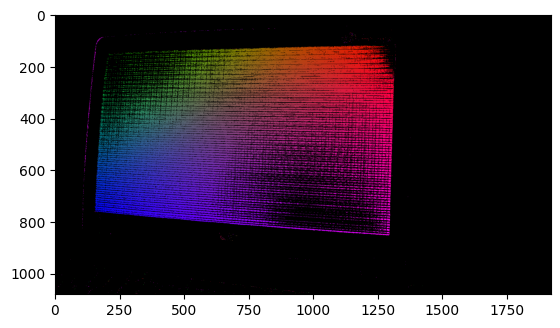

In [37]:
arrwidth = 800
arrheight = 600

r = arr_creat(0,   255, 0,   255)
g = arr_creat(0,   0,   255, 0)
b = arr_creat(255, 255, 0,   0)

img = np.concatenate([r, g, b], axis=2)

h_pixels = np.load('../data/recordings/record_0/h_pixels.npy')
v_pixels = np.load('../data/recordings/record_0/v_pixels.npy')

result_img = np.zeros((h_pixels.shape[0], h_pixels.shape[1], 3), dtype=int)

for i in range(h_pixels.shape[1]):
    for j in range(h_pixels.shape[0]):
        h_value = h_pixels[j, i]
        v_value = v_pixels[j, i]
        if h_value == -1 or v_value == -1:
            result_img[j, i] = [0, 0, 0]
        else:
            h_value = min(799, h_value)
            v_value = min(599, v_value)
            #print(h_value, v_value)
            result_img[j, i] = img[v_value, h_value]

plt.imshow(result_img)
plt.show()

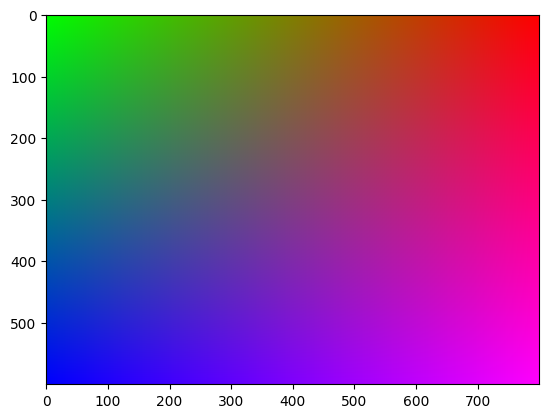

In [33]:
plt.imshow(img)